## Algoritmo de Maximización de la Esperanza
#### Estudiantes: Dennis Luna Acuña- Graciela Rivera Picado - Luis E. Vargas Porras

### Libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import scipy
from scipy.stats import entropy
from scipy.stats import norm
from torch.distributions import normal
from torch.distributions import multivariate_normal
from scipy import stats 
import seaborn as sns 

### 1. Generate data with Gaussian distribution

*The data are artificially created with a 2-cluster Gaussian distribution with specific means and variances.*

tensor([  2.8648,   3.3083,   0.1044,   2.7358,   4.4860,  -8.9876,   1.1485,
          9.6950,  -3.6788,   3.9363,  -1.7886,   4.2121,   5.2152,   5.2952,
          2.2927,   9.4963,  13.1850,   6.0478,  15.0264,   0.8894,   7.7897,
          6.0519,   4.6075,   1.1867,   2.8868,  11.7880,   5.1880,   6.2925,
          3.6702,  -0.8865,   7.0609,  -1.3470,   4.2516,   3.6336,   0.1166,
         10.0623,   0.7941,   2.2215,  -5.3893,   1.2037,   3.4643,   2.9050,
          5.9070,   4.6558,   3.0348,   5.3953,  10.6989,   0.8946,  11.5409,
          5.5976,   8.0132,   5.0570,   2.8922,  -2.9520,  -3.8698,  -1.3116,
          1.3963,  -2.0468,   3.4723,  -3.2157,  -4.0638,  -2.9813,   5.1865,
          2.0020,  -0.0811,  16.5396,  14.3848,  -0.2930,  -1.2104, -14.8558,
          0.9057,   0.3763,  -0.7733,   8.6594,   5.4328,   0.2478,   9.6075,
          1.2391,  -2.8942,   2.6118,   3.3946,   3.8932,   1.4357,   4.5203,
         10.2731,  -0.2482,   3.5860,   6.7388,   5.2272,   1.77

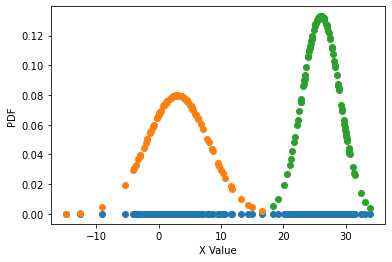

In [194]:
def createDataOneClass(means, std, numberSamplesPerClass):
    normal_dist = torch.distributions.Normal(means,std)
    gaussian_sample = normal_dist.sample((numberSamplesPerClass,1)).squeeze()
    
    return gaussian_sample


def generate_data(numberSamplesPerClass, mean1, mean2 , stds1 , stds2 ):
    """
    Creates the data to be used for training, using a GMM distribution
    @param numberSamplesPerClass, the number of samples per class
    @param mean1, means for samples from the class 1
    @param mean2, means for samples from the class 2
    @param stds1, standard deviation for samples, class 1
    @param stds2, standard deviation for samples, class 2    """

    samplesClass1 = createDataOneClass(mean1, stds1, numberSamplesPerClass)
    samplesClass2 = createDataOneClass(mean2, stds2, numberSamplesPerClass)
    #Concatenates
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    print (samplesAll)

    # Plot Data
    y = np.zeros_like(samplesAll)
    plt.scatter(samplesAll,y)
    #plt.title('Plotting)
    plt.xlabel('X Value')
    plt.ylabel('PDF')

    #Plot densities Functions
    plt.scatter(samplesClass1, norm.pdf(samplesClass1, mean1, stds1))
    plt.scatter(samplesClass2, norm.pdf(samplesClass2, mean2, stds2))      
    
    plt.show()
    
    return (samplesAll)

'''
Creates data with gaussian distribution
'''

#Call Function generate Data
X_samples = generate_data(numberSamplesPerClass=100, mean1=3.0, mean2=26.0, stds1=5.0, stds2=3.0)



### 2. Create init_random_parameters

In [195]:
def init_random_parameters(K=2, range_mean = [1,10], range_std = [1,5]):
    
    np.random.seed(2)    
    
    mean = torch.randint(range_mean[0],range_mean[1],(K,1))
    std  = torch.randint(range_std[0], range_std[1],(K,1))  
    
    W = torch.cat((mean, std), 1)
    
    return W

#test

W_parameters = init_random_parameters(K=2, range_mean = [1,100], range_std = [1,10])
W_parameters

tensor([[40,  4],
        [28,  2]])

### 3. Likelihood Gaussian Observation Function

In [196]:
#Propuesta2Gracielav1
def calculate_likelihood_gaussian_observation(x_n,mu_k,sigma_k):
    
    p_x1 = prob_density = (1/np.sqrt((2.0*np.pi*sigma_k[0]))) * np.exp(-0.5*((x_n- mu_k[0])/sigma_k[0])**2)
    p_x2 = prob_density = (1/np.sqrt((2.0*np.pi*sigma_k[1]))) * np.exp(-0.5*((x_n- mu_k[1])/sigma_k[1])**2) 
    #p_xAll = torch.Tensor([p_x1,p_x2])
    return p_x1,p_x2
    
calculate_likelihood_gaussian_observation(X_samples[0],mu_k=[10,20],sigma_k = [1.5,3])

(tensor(3.9762e-06), tensor(1.8975e-08))

In [197]:
#Propuesta2Graciela_conLOG
def calculate_likelihood_gaussian_observationLOG(x_n,mu_k1,sigma_k1,mu_k2,sigma_k2):
    
    p_x1 = prob_density = (1/np.sqrt((2.0*np.pi*sigma_k1))) * np.exp(-0.5*((x_n- mu_k1)/sigma_k1)**2)
    logp_x1= np.log(p_x1)
    p_x2 = prob_density = (1/np.sqrt((2.0*np.pi*sigma_k2))) * np.exp(-0.5*((x_n- mu_k2)/sigma_k2)**2)
    logp_x2 =  np.log(p_x2)
    return p_x1,p_x2,logp_x1,logp_x2

calculate_likelihood_gaussian_observationLOG(X_samples[1],mu_k1=10,sigma_k1=1.5,mu_k2=20,sigma_k2=3)

(tensor(1.5532e-05), tensor(4.3662e-08), tensor(-11.0726), tensor(-16.9468))

### 4. Calculate_membership

In [198]:
def calculate_membership_dataset(X_dataset,Parameters_matrix):
    #crear una matriz con ceros
    N = len(X_dataset)
    k = 2
    M = torch.zeros((N, k))
    
    #calculate_likelihood
    likelihood1,likelihood2 = calculate_likelihood_gaussian_observation(X_dataset,Parameters_matrix[:,0],Parameters_matrix[:,1])
    
    #print("likelihood2:", likelihood2.reshape([N, 1]))
    likelihoodALL = torch.cat((likelihood1.reshape([N, 1]), likelihood2.reshape([N, 1])), 1)
    
    M[:,0] = likelihoodALL[:,0] > likelihoodALL[:,1] 
    M[:,1] = likelihoodALL[:,0] < likelihoodALL[:,1] 
    
    return M

#fix_param = torch.tensor([[10,1.5],[20,3]])
Membership_Matrix = calculate_membership_dataset(X_samples,W_parameters)
Membership_Matrix


tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1

## 5. Recalculate_parameters

In [199]:
def recalculate_parameters(X_dataset,Membership_data): 
    
    #X1 = X_dataset[(Membership_data[:,0] == 1).nonzero(as_tuple=False)[0]]
    N = len(X_dataset)   
    
    X1 = torch.cat((X_dataset.reshape([N, 1]),Membership_data[:,0].reshape([N, 1])),1)
    X2 = torch.cat((X_dataset.reshape([N, 1]),Membership_data[:,1].reshape([N, 1])),1)
    
    X1_filtrada = X1[X1[:,1] == 1][:,0]
    X2_filtrada = X2[X2[:,1] == 1][:,0]
    
    mu_x1 = torch.mean(X1_filtrada)
    mu_x2 = torch.mean(X2_filtrada)
    
    sigma_x1 = torch.std(X1_filtrada)
    sigma_x2 = torch.std(X2_filtrada)
    
    new_W = torch.tensor([[mu_x1,sigma_x1],[mu_x2,sigma_x2]])
  
    return new_W
    
recalculate_parameters(X_samples,Membership_Matrix)
    

tensor([[ 3.7596,  7.1379],
        [26.0485,  3.1323]])

### 6. Corridas del Algoritmo

In [200]:
def corrida (R=20):
    
    W_parameters = init_random_parameters(K=2, range_mean = [1,100], range_std = [1,10])
    new_W = torch.tensor([[0,0],[0,0]])
    
    for i in range(R):
        if(i == 0):
            new_M = calculate_membership_dataset(X_samples,W_parameters)
        else:
            new_M = calculate_membership_dataset(X_samples,new_W)
        new_W = recalculate_parameters(X_samples,new_M)     
           
    # Plot Data
    y = np.zeros_like(X_samples)
    plt.scatter(X_samples,y)
    #plt.title('Plotting)
    plt.xlabel('X Value')
    plt.ylabel('PDF')

    #Plot densities Functions
    plt.scatter(samplesClass1, norm.pdf(samplesClass1, new_W[0,0], new_W[0,1]))
    plt.scatter(samplesClass2, norm.pdf(samplesClass2, new_W[1,0], new_W[1,1]))      
    
    plt.show()
    
    return new_W